In [16]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
import os
import requests
import zipfile
import shutil

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [17]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.657.jpg  
  inflating: cats_and_dogs/train/dogs/dog.131.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.131.jpg  
  inflating: cats_and_dogs/train/dogs/dog.119.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.119.jpg  
  inflating: cats_and_dogs/train/dogs/dog.74.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.74.jpg  
  inflating: cats_and_dogs/train/dogs/dog.60.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_do

In [18]:
# Initialize ImageDataGenerators for training, validation, and testing datasets
# ImageDataGenerator rescales the pixel values from [0, 255] to [0, 1]
train_image_gen = ImageDataGenerator(rescale=1.0 / 255)
val_image_gen = ImageDataGenerator(rescale=1.0 / 255)
test_image_gen = ImageDataGenerator(rescale=1.0 / 255)

# Create data generators for the training, validation, and test datasets
# train_data_gen and val_data_gen use the flow_from_directory method to read images
# and their labels directly from the directory structure
train_data_gen = train_image_gen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary'  # binary classification: cats vs dogs
)

val_data_gen = val_image_gen.flow_from_directory(
    validation_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    class_mode='binary'  # binary classification: cats vs dogs
)

# test_data_gen reads test images from the 'test' directory.
# We set shuffle=False to ensure the predictions are in the correct order
test_data_gen = test_image_gen.flow_from_directory(
    PATH,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=batch_size,
    classes=['test'],  # specifying the directory containing test images
    shuffle=False  # maintain the order of images for prediction consistency
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


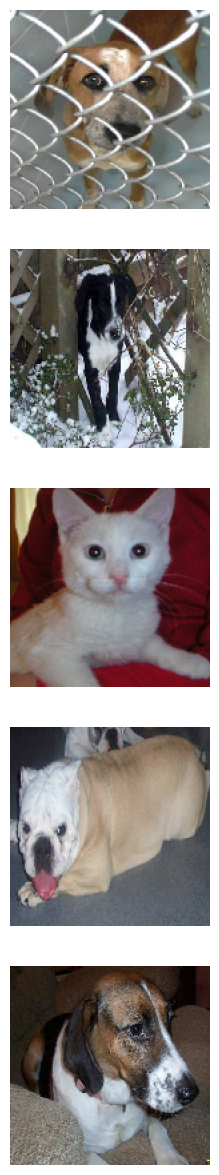

In [19]:
# Function to plot images with optional class probabilities
def plotImages(images_arr, probabilities=False):
    # Create a figure with a row of subplots equal to the number of images
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5, len(images_arr) * 3))

    # If no probabilities are provided, simply display the images
    if probabilities is False:
        for img, ax in zip(images_arr, axes):
            ax.imshow(img)   # Display image
            ax.axis('off')   # Hide axis
    else:
        # If probabilities are provided, display the images with class labels
        for img, probability, ax in zip(images_arr, probabilities, axes):
            ax.imshow(img)   # Display image
            ax.axis('off')   # Hide axis

            # Determine and display class label based on probability
            if probability > 0.5:
                ax.set_title("%.2f" % (probability * 100) + "% dog")  # Probability as dog
            else:
                ax.set_title("%.2f" % ((1 - probability) * 100) + "% cat")  # Probability as cat

    plt.show()  # Display the plot

# Generate a batch of training images
sample_training_images, _ = next(train_data_gen)

# Plot the first 5 images from the batch
plotImages(sample_training_images[:5])

In [20]:
# Create an ImageDataGenerator for the training data with data augmentation
train_image_generator = ImageDataGenerator(
    rescale=1./255,             # Rescale pixel values from [0, 255] to [0, 1]
    horizontal_flip=True,       # Randomly flip images horizontally
    rotation_range=20,          # Randomly rotate images by up to 20 degrees
    zoom_range=0.15,            # Randomly zoom in on images by up to 15%
    width_shift_range=0.2,      # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2,     # Randomly shift images vertically by up to 20% of the height
    shear_range=0.15,           # Randomly apply shearing transformations by up to 15%
    fill_mode="nearest"         # Fill in missing pixels after transformations with the nearest value
)


Found 2000 images belonging to 2 classes.


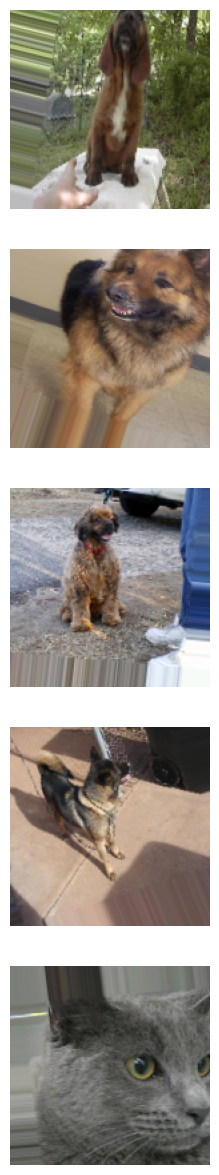

In [21]:
# Generate batches of tensor image data with real-time data augmentation
train_data_gen = train_image_generator.flow_from_directory(
    batch_size=batch_size,             # Size of the batches of data
    directory=train_dir,               # Path to the target directory
    target_size=(IMG_HEIGHT, IMG_WIDTH), # Resize all images to the target height and width
    class_mode='binary'                # Return 2D binary labels for classification
)

# Extract five augmented images from the first batch for visualization
augmented_images = [train_data_gen[0][0][i] for i in range(5)]

# Plot the five augmented images
plotImages(augmented_images)

In [22]:
# Create a Sequential model
model = Sequential()

# Convolutional layers
model.add(Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))) # Input layer with shape of input images
model.add(Conv2D(32, (3, 3), activation='relu'))   # First Conv2D layer with 32 filters, 3x3 kernel size, and ReLU activation
model.add(MaxPooling2D(pool_size=(2, 2)))          # First MaxPooling2D layer with 2x2 pool size
model.add(Conv2D(64, (3, 3), activation='relu'))   # Second Conv2D layer with 64 filters, 3x3 kernel size, and ReLU activation
model.add(MaxPooling2D(pool_size=(2, 2)))          # Second MaxPooling2D layer with 2x2 pool size
model.add(Conv2D(128, (3, 3), activation='relu'))  # Third Conv2D layer with 128 filters, 3x3 kernel size, and ReLU activation
model.add(MaxPooling2D(pool_size=(2, 2)))          # Third MaxPooling2D layer with 2x2 pool size

# Dense layers
model.add(Flatten())                               # Flatten the output of the last pooling layer to feed into fully connected layers
model.add(Dense(512, activation='relu'))           # Dense layer with 512 units and ReLU activation
model.add(Dense(1, activation='sigmoid'))          # Output layer with 1 unit and sigmoid activation for binary classification

# Compile the model with Adam optimizer and binary cross-entropy loss
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])                # Track accuracy during training

# Print the model summary
model.summary()                                    # Display the model's architecture

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 17, 17, 128)      

In [23]:
# Calculate the number of steps per epoch for training and validation
train_steps = int(ceil(1. * total_train / batch_size))  # Number of training steps per epoch
val_steps = int(ceil(1. * total_val / batch_size))      # Number of validation steps per epoch

# Train the model
history = model.fit(
    train_data_gen,                # Training data generator
    validation_data=val_data_gen,  # Validation data generator
    epochs=epochs                  # Number of epochs to train
)

Epoch 1/15
16/16 [==============================] - 18s 1s/step - loss: 1.2307 - accuracy: 0.5115 - val_loss: 0.6997 - val_accuracy: 0.5000
Epoch 2/15
16/16 [==============================] - 17s 1s/step - loss: 0.6872 - accuracy: 0.5375 - val_loss: 0.6684 - val_accuracy: 0.5470
Epoch 3/15
16/16 [==============================] - 17s 1s/step - loss: 0.6695 - accuracy: 0.5580 - val_loss: 0.7225 - val_accuracy: 0.5080
Epoch 4/15
16/16 [==============================] - 16s 995ms/step - loss: 0.6645 - accuracy: 0.5710 - val_loss: 0.6473 - val_accuracy: 0.6070
Epoch 5/15
16/16 [==============================] - 16s 1s/step - loss: 0.6748 - accuracy: 0.5925 - val_loss: 0.6470 - val_accuracy: 0.6320
Epoch 6/15
16/16 [==============================] - 16s 993ms/step - loss: 0.6419 - accuracy: 0.6200 - val_loss: 0.6232 - val_accuracy: 0.6500
Epoch 7/15
16/16 [==============================] - 16s 993ms/step - loss: 0.6249 - accuracy: 0.6435 - val_loss: 0.6129 - val_accuracy: 0.6670
Epoch 8/15


Text(0.5, 1.0, 'Training and Validation Loss')

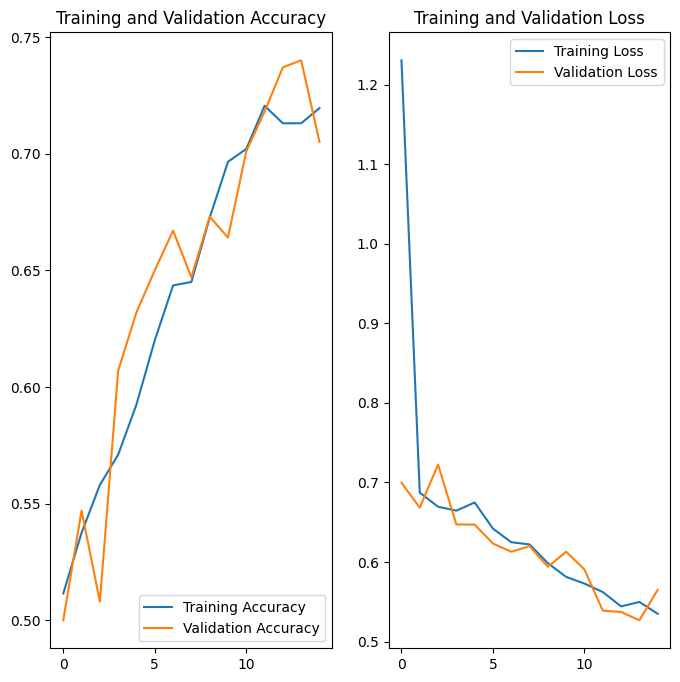

In [24]:
# Extract accuracy values from the training history
acc = history.history['accuracy']         # Training accuracy
val_acc = history.history['val_accuracy'] # Validation accuracy

# Extract loss values from the training history
loss = history.history['loss']         # Training loss
val_loss = history.history['val_loss'] # Validation loss

# Create a range object for the number of epochs
epochs_range = range(epochs)

# Plot training and validation accuracy
plt.figure(figsize=(8, 8))

# Create a subplot for accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')  # Plot training accuracy
plt.plot(epochs_range, val_acc, label='Validation Accuracy')  # Plot validation accuracy
plt.legend(loc='lower right')  # Add a legend in the lower right corner
plt.title('Training and Validation Accuracy')  # Set the title for accuracy plot

# Create a subplot for loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')  # Plot training loss
plt.plot(epochs_range, val_loss, label='Validation Loss')  # Plot validation loss
plt.legend(loc='upper right')  # Add a legend in the upper right corner
plt.title('Training and Validation Loss')  # Set the title for loss plot

In [25]:
# Predict probabilities for the test dataset
probabilities = model.predict(test_data_gen).flatten()

# Display the predicted probabilities
probabilities

1/1 [==============================] - 0s 180ms/step


array([0.80021614, 0.30130434, 0.03403739, 0.97452796, 0.7061676 ,
       0.5693366 , 0.90086114, 0.19705196, 0.72170126, 0.99406   ,
       0.28441864, 0.7381858 , 0.27338874, 0.43656215, 0.7959187 ,
       0.93944967, 0.9005727 , 0.98816866, 0.6999133 , 0.8591622 ,
       0.17567226, 0.6819393 , 0.3872409 , 0.6773457 , 0.8511568 ,
       0.3980128 , 0.9959486 , 0.4575451 , 0.5323282 , 0.77652454,
       0.33639267, 0.24659884, 0.942932  , 0.99997103, 0.44311142,
       0.9181138 , 0.99976605, 0.8688522 , 0.39881   , 0.47691974,
       0.48316297, 0.6673061 , 0.9899199 , 0.89218956, 0.41622117,
       0.62521774, 0.5854499 , 0.09870497, 0.41875544, 0.60932404],
      dtype=float32)

In [26]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 66.0% of the images of cats and dogs.
You passed the challenge!
